### Document Clustering
This notebook demonstrates a simple document clustering workflow, including visual cluster validation, using mean fasttext embeddings. This notebook is quite rough but communicates the main steps.

In [1]:
# Imports.
import nltk
import numpy as np
import pandas as pd
from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktTrainer
from nltk.corpus import stopwords
import csv
import umap.umap_ as umap
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
import collections
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.cluster import AgglomerativeClustering
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns
import matplotlib.cm as cm
import fasttext
import hdbscan

In [2]:
# GLobal variables.
STOP_WORDS = set(stopwords.words('english'))

In [3]:
# TF-IDF vectorizer.
vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1,1),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=STOP_WORDS)

# Get most relevant words from tf-idf.
def get_tfidf(corpus):
    scores = {}
    # Matrix of scored terms for each comment in the corpus.
    tfidf_matrix =  vectorizer.fit_transform(corpus)
    # Mapping of terms to matrix ids.
    feature_names = vectorizer.get_feature_names()
    # For each comment extract the terms and scores and append them to a dictionary.
    for i in range(len(corpus)):
        feature_index = tfidf_matrix[i,:].nonzero()[1]
        tfidf_scores = zip([feature_names[y] for y in feature_index], [tfidf_matrix[i, x] for x in feature_index])
        scores.update(dict(tfidf_scores))
    return scores

In [6]:
# Load FastText common crawl model.
vector_path = './crawl-300d-2M-subword.bin'
model = fasttext.load_model(vector_path)

In [7]:
# Load raw dataset.
df_raw = pd.read_csv("res/bbc.csv")
df_raw.head(5)

,text,label
0,French wine gets 70m euro top-up The French g...,business
1,Steady job growth continues in US The US crea...,business
2,S&N extends Indian beer venture The UK's bigg...,business
3,Unilever shake up as profit slips Anglo-Dutch...,business
4,Circuit City gets takeover offer Circuit City...,business


In [8]:
# Train sentence tokenizer.
corpus = ''
for index, row in df_raw.iterrows():
    corpus += row['text'].lower().replace('•', '') + ' '

# NLTK function for building tokenization model based on our comment data.
trainer = PunktTrainer()
trainer.INCLUDE_ALL_COLLOCS = True
trainer.train(corpus)
tokenizer = PunktSentenceTokenizer(trainer.get_params())

In [9]:
# Sentence tokenize the comments.
comments_tokenized = []
for index, row in df_raw.iterrows():
    for sentence in tokenizer.tokenize(row['text']):
        text = sentence.lower().replace('•', '')
        comments_tokenized.append({'text': text})

In [10]:
# Load sentence tokenized comments to a new df.
df_tokenized = pd.DataFrame(comments_tokenized)
df_tokenized.head(5)

,text
0,french wine gets 70m euro top-up the french g...
1,the financial package is aimed at assisting vi...
2,"the french wine industry, the world's second l..."
3,"wine makers, however, claimed the support did ..."
4,the package was announced by agriculture minis...


In [11]:
# Mean embeddings for each sentence.

# Write to a csv so we have the results saved on the disk.
with open('data.csv', 'w', newline='', encoding='utf-8') as f:
    headers = ['text', 'mean_embedding']
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()
    for index, row in df_tokenized.iterrows():
        # Ignore stop words.
        tokens = [w for w in nltk.tokenize.word_tokenize(row['text']) if not w in STOP_WORDS]
        if len(tokens) > 1:
            embeddings = []
            for token in tokens:
                try:
                    embeddings.append(model[token])
                
                # Ignore the word if the model can't vectorize it.
                except KeyError as e:
                    pass

            # Compute mean embeddings.
            mean_embedding = np.array(embeddings).mean(axis=0)    

        # If there is only one valid word we ignore it and return a null value for that sentence.
        else:
            mean_embedding = np.array([np.nan])
    
        # Write the final results to the csv.
        writer.writerow({'text': row['text'],
                         'mean_embedding': mean_embedding.tolist()})

In [12]:
# Load and inspect new df.
df_embeddings = pd.read_csv('data.csv')
print(df_embeddings.head(1))

                                                text  \
0  french wine gets 70m euro top-up  the french g...   

                                      mean_embedding  
0  [-0.007988844998180866, 0.009376421570777893, ...  


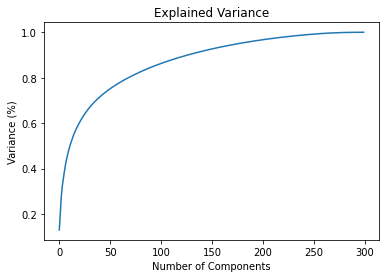

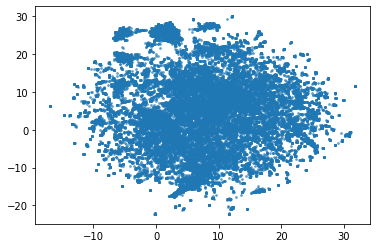

Number of outliers: 5095


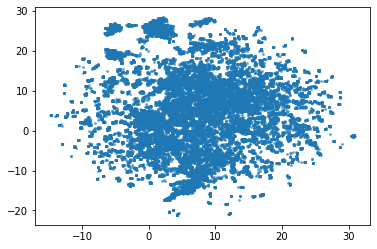

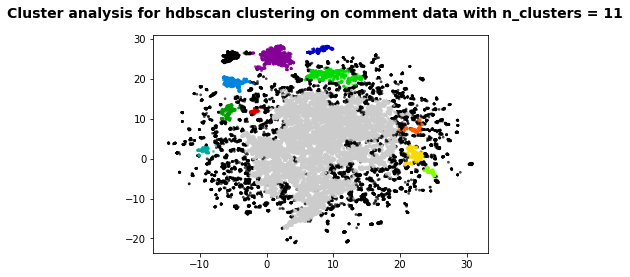

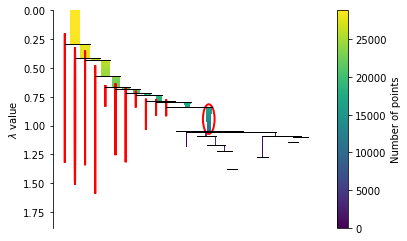

In [13]:
# Cluster validation for each question.

# Rewrite the csv.
with open('data_tm.csv', 'w', newline='', encoding='utf-8') as f:
    headers = ['text', 'mean_embedding', 'x', 'y', 'Cluster ID']
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()
    embeddings = []
    comments = []

    for index, row in df_embeddings.iterrows():
        # Exclude embeddings with nan values.
        if len(row['mean_embedding']) > 6:
            embeddings.append(np.asarray(eval(row['mean_embedding'])))
            comments.append(row['text'])

    X = np.array(embeddings)
    C = np.array(comments)

    # Normalize values between 0 and 1. 
    scaler = MinMaxScaler(feature_range=[0, 1])
    data_rescaled = scaler.fit_transform(X)

    #Plot the cumulative summation of the explained variance.
    pca = PCA().fit(data_rescaled)
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') #for each component
    plt.title('Explained Variance')
    plt.show()

    # Reduce dimensions for performance while maintaining majority of variance.
    pca = PCA(n_components=150)
    data = pca.fit_transform(data_rescaled)

    # Perform UMAP dimensionality reduction to more cleanly separate clusters and improve performance.
    reducer = umap.UMAP(random_state=42, min_dist=0.0, spread=5, n_neighbors=19)
    data_reduced = reducer.fit(data).embedding_
    plt.scatter(data_reduced[:, 0], data_reduced[:, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k')
    plt.show()

    # Remove a certain percentage of outliers. Show the number of outliers.
    outlier_scores = LocalOutlierFactor(contamination=0.15).fit_predict(data_reduced)
    outlying_digits = data_reduced[outlier_scores == -1]
    print(f'Number of outliers: {outlying_digits.shape[0]}')

    # Transform all the lists according to the inlier data.        
    data_inliers = data_reduced[outlier_scores == 1]
    embeddings_inliers = X[outlier_scores == 1]
    comments_inliers = C[outlier_scores == 1]

    # Confirm that all the arrays are still the same length.
    if not len(data_inliers) == len(comments_inliers) == len(embeddings_inliers):
        print('Check your data. Something is faulty with the outliers.')

    # Visualize the inlier data.
    plt.scatter(data_inliers[:, 0], data_inliers[:, 1], marker='.', s=30, lw=0, alpha=0.7, edgecolor='k')
    plt.show()

    # Cluster using hdbscan algorith, which identifies dense regions based on min_cluster size.
    # The algorithm also scores 'unclustered' points with a label -1.
    clusterer = hdbscan.HDBSCAN(algorithm='best', 
                                alpha=1.0, 
                                approx_min_span_tree=True,
                                gen_min_span_tree=False, 
                                leaf_size=40,
                                metric='euclidean', 
                                min_cluster_size=100, 
                                min_samples=None, 
                                p=None)

    clusterer.fit(data_inliers)
    cluster_labels = clusterer.labels_

    # Visualize the clusters.
    colors = cm.nipy_spectral(cluster_labels.astype(float) / clusterer.labels_.max())
    plt.scatter(data_inliers[:, 0], data_inliers[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    plt.suptitle(("Cluster analysis for hdbscan clustering on comment data"
                  " with n_clusters = %d" % clusterer.labels_.max()),
                 fontsize=14, fontweight='bold')

    plt.show()

    # Show a tree plot of how the clusters were formed.
    clusterer.condensed_tree_.plot(select_clusters=True,
                                   selection_palette=sns.color_palette('deep', 8))   

    # Write everything to the csv.
    for i in range(len(data_inliers)):
        writer.writerow({'text': comments_inliers[i],
                         'mean_embedding': embeddings_inliers[i],
                         'x': data_inliers[i][0],
                         'y': data_inliers[i][1],
                         'Cluster ID': cluster_labels[i]})

In [17]:
# Load the new df.
df_clustered = pd.read_csv('data_tm.csv')
df_clustered.head(10)

,text,mean_embedding,x,y,Cluster ID
0,french wine gets 70m euro top-up the french g...,[-7.98884500e-03 9.37642157e-03 5.88890351e-...,-4.568030,25.357630,0
1,the financial package is aimed at assisting vi...,[ 2.48141796e-03 9.42749728e-04 4.97549810e-...,11.941592,-4.526693,-1
2,"the french wine industry, the world's second l...",[-1.73929445e-02 -2.11663544e-04 3.79196815e-...,11.271716,4.253916,11
3,"wine makers, however, claimed the support did ...",[ 2.70065828e-03 -1.56796798e-02 3.99486646e-...,3.910704,10.497481,11
4,the package was announced by agriculture minis...,[-6.44986480e-02 -9.28293355e-03 1.74491424e-...,-5.871806,11.109528,5
5,the bulk of the money - about 40m euros - will...,[-6.17256016e-02 3.66139482e-03 4.24311757e-...,9.854913,21.915037,6
6,efforts to promote french wine abroad are to b...,[-1.21281734e-02 1.09476701e-03 6.67117685e-...,3.986051,1.832063,11
7,"domestic consumption, accounting for 70% of sa...",[-7.00840168e-03 1.34266308e-03 4.95637730e-...,0.308328,25.239737,1
8,"the aid package would ""create a positive clima...",[-1.31895952e-02 -3.93456640e-03 1.74913164e-...,-1.549116,2.515218,11
9,"however, wine makers and farmers said the supp...",[ 1.01874834e-02 1.62823161e-03 4.90844212e-...,21.179167,-13.491456,-1


In [18]:
# Assign cluster labels based on TF-IDF key words.

# Rewrite the csv.
with open('data.csv', 'w', newline='', encoding='utf-8') as f:
    headers = ['text', 'mean_embedding', 'x', 'y', 'Cluster ID', 'Cluster Keywords']
    writer = csv.DictWriter(f, fieldnames=headers)
    writer.writeheader()
            
    # Within question, group by cluster.
    for name, cluster in df_clustered.groupby(['Cluster ID']):

        # Extract everything to lists (this step is kinda messy).
        cluster_ids = []
        cluster_keywords = []
        comments = []
        x = []
        y = []
        embeddings = []

        for index, row in cluster.iterrows():
            embeddings.append(row['mean_embedding'])
            comments.append(row['text'])
            x.append(row['x'])
            y.append(row['y'])
            cluster_ids.append(row['Cluster ID'])

        # Compute TF-IDF for all comments in the cluster.
        keywords = [key[0] for key in sorted(list(get_tfidf(comments).items()), key=lambda x: x[1], reverse=True)][0:10]
        for index, row in cluster.iterrows():
            cluster_keywords.append(keywords)

        # Write everything to the csv.
        for i in range(len(comments)):
            writer.writerow({'text': comments[i],
                            'mean_embedding': embeddings[i],
                             'x': x[i],
                             'y': y[i],
                            'Cluster ID': cluster_ids[i],
                            'Cluster Keywords': cluster_keywords[i]})

In [19]:
# Load the final csv.
df_labeled = pd.read_csv('data.csv')

In [20]:
# Drop comments for which hdbscan could not find a good cluster.
outliers = df_labeled[ df_labeled['Cluster ID'] == -1 ].index
df_labeled.drop(outliers , inplace=True)

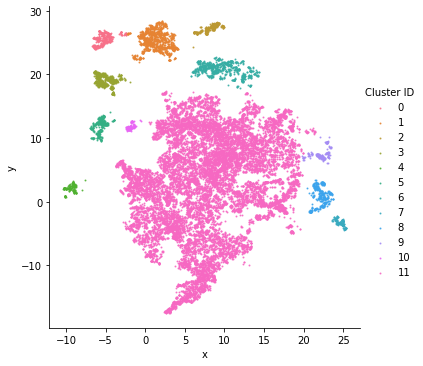

Cluster 0: ['Fiat', '280Bn', '12', '149', 'Auction', 'Billion', 'Project', 'Price', 'Japan', 'Sued'] 

french wine gets 70m euro top-up  the french government is to hand its struggling wine industry 70m euros ($91m) in aid to help it battle falling sales and damaging overproduction.
circuit city gets takeover offer  circuit city stores, the second-largest electronics retailer in the us, has received a $3.25bn (£1.7bn) takeover offer.
tsunami to cost sri lanka $1.3bn  sri lanka faces a $1.3bn (£691m) bill in 2005 for reconstruction after the tsunami which killed more than 30,000 of its people, its central bank says.
the bank has 5bn rupees ($50m; £27m) set aside to lend at a lower interest rate to those who lost property.
yuganskneftegaz, the unit which produced 60% of yukos' output, had been seized and sold in december for less than $10bn to a previously unknown firm called baikal.  baikal promptly passed into the hands of state-controlled firm rosneft, itself shortly to merge with sta

In [25]:
# Visualize the UMAP reduced data with the cluster IDs.
facet = sns.lmplot(data=df_labeled, x='x', y='y', hue='Cluster ID', 
                   fit_reg=False, legend=True, legend_out=True, scatter_kws={"s": 1})
plt.show()

# Show some of the comments for each cluster.
for name_cluster, cluster in df_labeled.groupby(['Cluster ID']):
    cluster_name = cluster.head(1)['Cluster Keywords'].tolist()[0]
    print(f'Cluster {name_cluster}: {cluster_name.title()} \n')
    print(*cluster.head(5)['text'].tolist(), sep='\n')
    print('\n\n')

### NOTE
It is clear from these data that the approach allows us to identify some salient semantic groups in the data. Notably a topic about wine (11) and another related to television (10). However, the results alone are difficult to interpret and warrant further optimization/preprocessing.